# Convolutional Neural Networks (CNNs)

### HW2 @ DL Course, Dr. Soleymani

*Full Name:* Amirhossein Alamdar

*SID:* 400105144

In this homework, you will work with [Google colab](https://colab.research.google.com/). Google colab allows you to run a jupyter notebook on Google servers using a GPU/TPU. To enable GPU support, make sure to press `Runtime -> Change Runtime Type -> GPU`.

## Task: Cats vs Dogs

To learn about CNNs we will be working on a problem of great importance in computer vision, **classifying images of cats and dogs** :)

The problem is so important that there's even an easter egg in colab: go to `Tools -> Settings -> Miscellaneous and enable 'Kitty mode' and 'Corgi mode'` to get more cats and dogs to classify when you're tired of coding :)

In [ ]:
from tqdm.notebook import tqdm
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image
from matplotlib import pyplot as plt


### Getting the data

To get started with the classification, we first need to download and unpack the dataset (note that in jupyter notebooks commands starting with `!` are executed in bash, not in python):

In [ ]:
! wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O ./cats_and_dogs_filtered.zip

--2024-03-30 08:16:18--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.188.207, 64.233.189.207, 108.177.97.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.188.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘./cats_and_dogs_filtered.zip’

./cats_and_dogs_fil 100%[===================>]  65.43M  23.0MB/s    in 2.8s    

2024-03-30 08:16:21 (23.0 MB/s) - ‘./cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
! unzip -q cats_and_dogs_filtered.zip

### Dataset Organization
Our dataset contains two directories, `train` and `validation`, both containing two directories with images: `cats` and `dogs`. In `train` we have 1000 images of cats and 1000 images of dogs. For `validation`, we have 500 images of each class. Our goal is to implement and train a CNN to classify these images, i.e. given an image from this dataset, tell if it contains a *cat* or a *dog*.

```bash
├── dir.txt
├── train
│   ├── cats
│   │   ├── cat.0.jpg
│   │   ├── cat....jpg
│   │   ├── cat.999.jpg
│   └── dogs
│       ├── dog.0.jpg
│       ├── dog....jpg
│       ├── dog.999.jpg
├── validation
│   ├── cats
│   │   ├── cat.2000.jpg
│   │   ├── cat....jpg
│   │   └── cat.2499.jpg
│   └── dogs
│       ├── dog.2000.jpg
│       ├── dog....jpg
│       └── dog.2499.jpg
└── vectorize.py

6 directories, 3002 files
```

### Loading the data
 Now that we have the data on our disk, we need to load it so that we can use it to train our model. In Pytorch, we use `Dataset` class, documentation for which can be found [here](https://pytorch.org/docs/stable/data.html).

 Torchvision is a Pytorch library with many commonly used tools in computer vision. In the case of computer vision, the datasets with the folder structure `label_name/image_file` are very common, and to process those there's already an implemented class `torchvision.datasets.ImageFolder` (documented [here](https://pytorch.org/vision/0.8/datasets.html)).

 Another thing we need from Torchvision library is [transforms](https://pytorch.org/docs/stable/torchvision/transforms.html). In computer vision, we very often want to transform the images in certain ways. The most common is **normalization**. Others include *flipping*, changing *saturation*, *hue*, *contrast*, *rotation*, and *blurring*.

 Below, we create training, validation and test sets. We use a few transforms for **augmentation** on the training set, but we don't use anything but **resize** and **normalization** for validation and test.

In [ ]:

# These numbers are mean and std values for channels of natural images.
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

# Inverse transformation which is needed for plotting.
inv_normalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

train_transforms = transforms.Compose([
                                    transforms.Resize((256, 256)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ColorJitter(hue=.1, saturation=.1, contrast=.1),
                                    transforms.RandomRotation(20, interpolation=Image.Resampling.BILINEAR),
                                    transforms.GaussianBlur(7, sigma=(0.1, 1.0)),
                                    transforms.ToTensor(), # This is necessary to convert PIL to torch Tensor
                                    normalize,
                                ])

validation_transforms = transforms.Compose([
                                    transforms.Resize((256, 256)),
                                    transforms.ToTensor(),
                                    normalize,
                                ])

train_dataset = torchvision.datasets.ImageFolder('./cats_and_dogs_filtered/train', transform=train_transforms)
test_dataset = torchvision.datasets.ImageFolder('./cats_and_dogs_filtered/validation', transform=validation_transforms)

validation_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [500, 500], generator=torch.Generator().manual_seed(42))

### Dataset Inspection
Let's see what one of the images in the dataset looks like (you can run this cell multiple times to see the effects of different augmentations):

torch.Size([3, 256, 256])


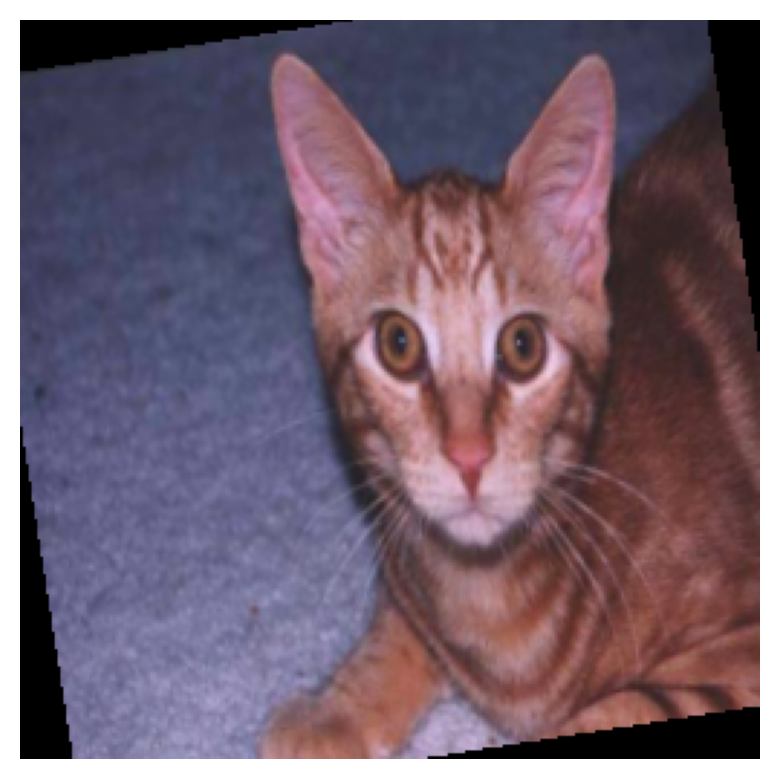

In [ ]:
plt.rcParams['figure.dpi'] = 200 # change dpi to make plots bigger

def show_normalized_image(img, title=None):
    plt.imshow(inv_normalize(img).detach().cpu().permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')

print(train_dataset[10][0].shape)
show_normalized_image(train_dataset[10][0])

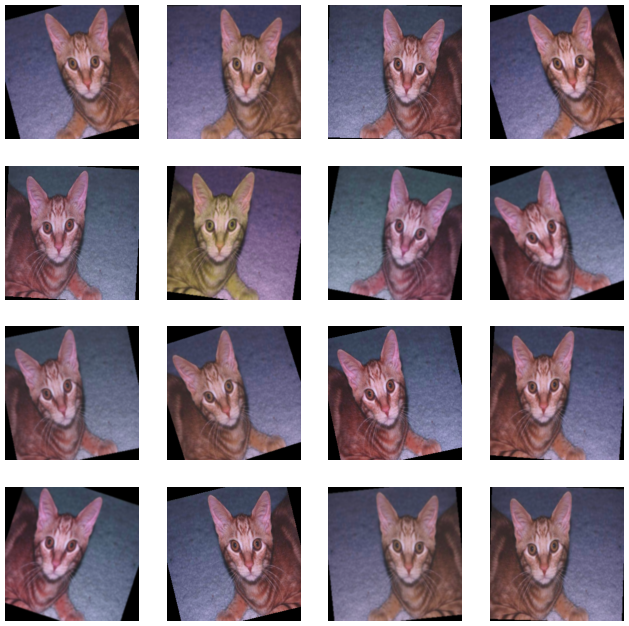

In [ ]:
# checking the augmentation
plt.rcParams['figure.dpi'] = 50
plt.figure(figsize=(16,16))
for i in range(16):
    plt.subplot(4, 4, i+1)
    show_normalized_image(train_dataset[10][0])
plt.show()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Creating the model

Now is the time to create a model.

All models in Pytorch are subclassing `torch.nn.Module`. We have to implement `__init__` and `forward` methods.

Below we provide a simple model skeleton, which you need to expand. The places to put your code are marked with `TODO`. Here, we ask you to implement a CNN containing the following elements:

* Convolutional layers (at least two)
* Pooling layers
* Non-linearity
* Residual connections similar to that of **ResNet**
* fully connected layer(s)

Note that you cannot use Batch Normalization layers in this step.

In [ ]:
class CNN_cat_dog(torch.nn.Module):

    def __init__(self, in_channel):
        super().__init__()
        self.relu = nn.ReLU()

        # input 256 output 128
        self.conv1 = nn.Conv2d(in_channels = in_channel, out_channels = 64, kernel_size = (7, 7), padding = (3, 3))
        self.maxp1 = nn.MaxPool2d(kernel_size=(2, 2))

        # input 128 output 128
        self.conv2 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = (5, 5), padding = (2, 2))

        # input 128 output 32
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (3, 3), padding = (1, 1), stride = (2, 2))
        self.maxp2  = nn.MaxPool2d(kernel_size = (2, 2))

        self.conv4 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = (3, 3), padding = (1, 1))

        # input 32 output 8
        self.conv5 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = (3, 3), padding = (1, 1), stride = (2, 2))
        self.maxp3  = nn.MaxPool2d(kernel_size = (2, 2))

        self.conv6 = nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = (8, 8), padding =0)

        self.fc = nn.Linear(in_features = 512, out_features = 1000)
        self.out = nn.Linear(in_features = 1000, out_features = 1)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # TODO
        x = self.conv1(x)
        x = self.maxp1(x)
        x = self.relu(x)

        y = self.conv2(x)
        x = x + y
        self.relu(x)

        x = self.conv3(x)
        x = self.maxp2(x)
        x = self.relu(x)

        y = self.conv4(x)
        x = x + y
        x = self.relu(x)

        x = self.conv5(x)
        x = self.maxp3(x)
        x = self.relu(x)

        x = self.conv6(x)
        x = self.relu(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return self.sigmoid(self.out(x))


In [ ]:
model = CNN_cat_dog(3)
model.to(device)

CNN_cat_dog(
  (relu): ReLU()
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (maxp1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (maxp2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (maxp3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv6): Conv2d(256, 512, kernel_size=(8, 8), stride=(1, 1))
  (fc): Linear(in_features=512, out_features=1000, bias=True)
  (out): Linear(in_features=1000, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

### Training the model

Now we train the model on the dataset. Again, we're providing you with the skeleton with some parts marked as `TODO` to be filled by you.

In [ ]:


def get_loss_and_correct(model, batch, criterion, device, eval = True):
    # Implement forward pass and loss calculation for one batch.
    # Remember to move the batch to device.
    #
    # Return a tuple:
    # - loss for the batch (Tensor)
    # - number of correctly classified examples in the batch (Tensor)
    # Set model to evaluation mode
    if eval:
      model.eval()

    inputs, targets = batch
    inputs, targets = inputs.to(device), targets.to(device)

    outputs = model(inputs)
    # print(outputs)
    # print(outputs.shape)
    targets = targets.view(targets.shape[0], 1).float()
    # targets = targets.float()


    # print(outputs.dtype, targets.dtype)

    loss = criterion(outputs, targets)
    # _, predicted = torch.max(outputs, 1)
    predicted = torch.round(outputs)
    # print(predicted)
    correct = (predicted == targets).sum().item()

    return loss, correct


def step(loss, optimizer):
    # Implement backward pass and update.
    # TODO
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
N_EPOCHS = 20
BATCH_SIZE = 64

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, num_workers=2)
model = CNN_cat_dog(3)
model.to(device)

criterion = nn.BCELoss() # TODO
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001) # TODO

model.train()

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

pbar = tqdm(range(N_EPOCHS))

for i in pbar:
    total_train_loss = 0.0
    total_train_correct = 0.0
    total_validation_loss = 0.0
    total_validation_correct = 0.0
    best_val_accuracy = 0.0
    model.train()

    for batch in tqdm(train_dataloader, leave=False):
        # use `get_loss_and_correct` to perform a step and save train loss and corrects
        # TODO
        loss, correct = get_loss_and_correct(model, batch, criterion, device, False)
        step(loss, optimizer)

        total_train_loss += loss.item()
        total_train_correct += correct

    with torch.no_grad():
        for batch in validation_dataloader:
            # use `get_loss_and_correct` to perform a step and save validation loss and corrects
            # TODO
            loss, correct = get_loss_and_correct(model, batch, criterion, device)
            total_validation_correct += correct
            total_validation_loss += loss.item()


    mean_train_loss = total_train_loss / len(train_dataloader.dataset) # TODO
    train_accuracy = total_train_correct / len(train_dataloader.dataset) # TODO

    mean_validation_loss = total_validation_loss / len(validation_dataloader.dataset) # TODO
    validation_accuracy = total_validation_correct / len(validation_dataloader.dataset) # TODO

    if validation_accuracy > best_val_accuracy:
        torch.save(model.state_dict(), 'best_model.pth')  # Save the model's state_dict
        best_val_accuracy = validation_accuracy


    train_losses.append(mean_train_loss)
    validation_losses.append(mean_validation_loss)

    train_accuracies.append(train_accuracy)
    validation_accuracies.append(validation_accuracy)

    pbar.set_postfix({'train_loss': mean_train_loss, 'validation_loss': mean_validation_loss, 'train_accuracy': train_accuracy, 'validation_accuracy': validation_accuracy})

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Now that the model is trained, we want to visualize the training and validation losses and accuracies:

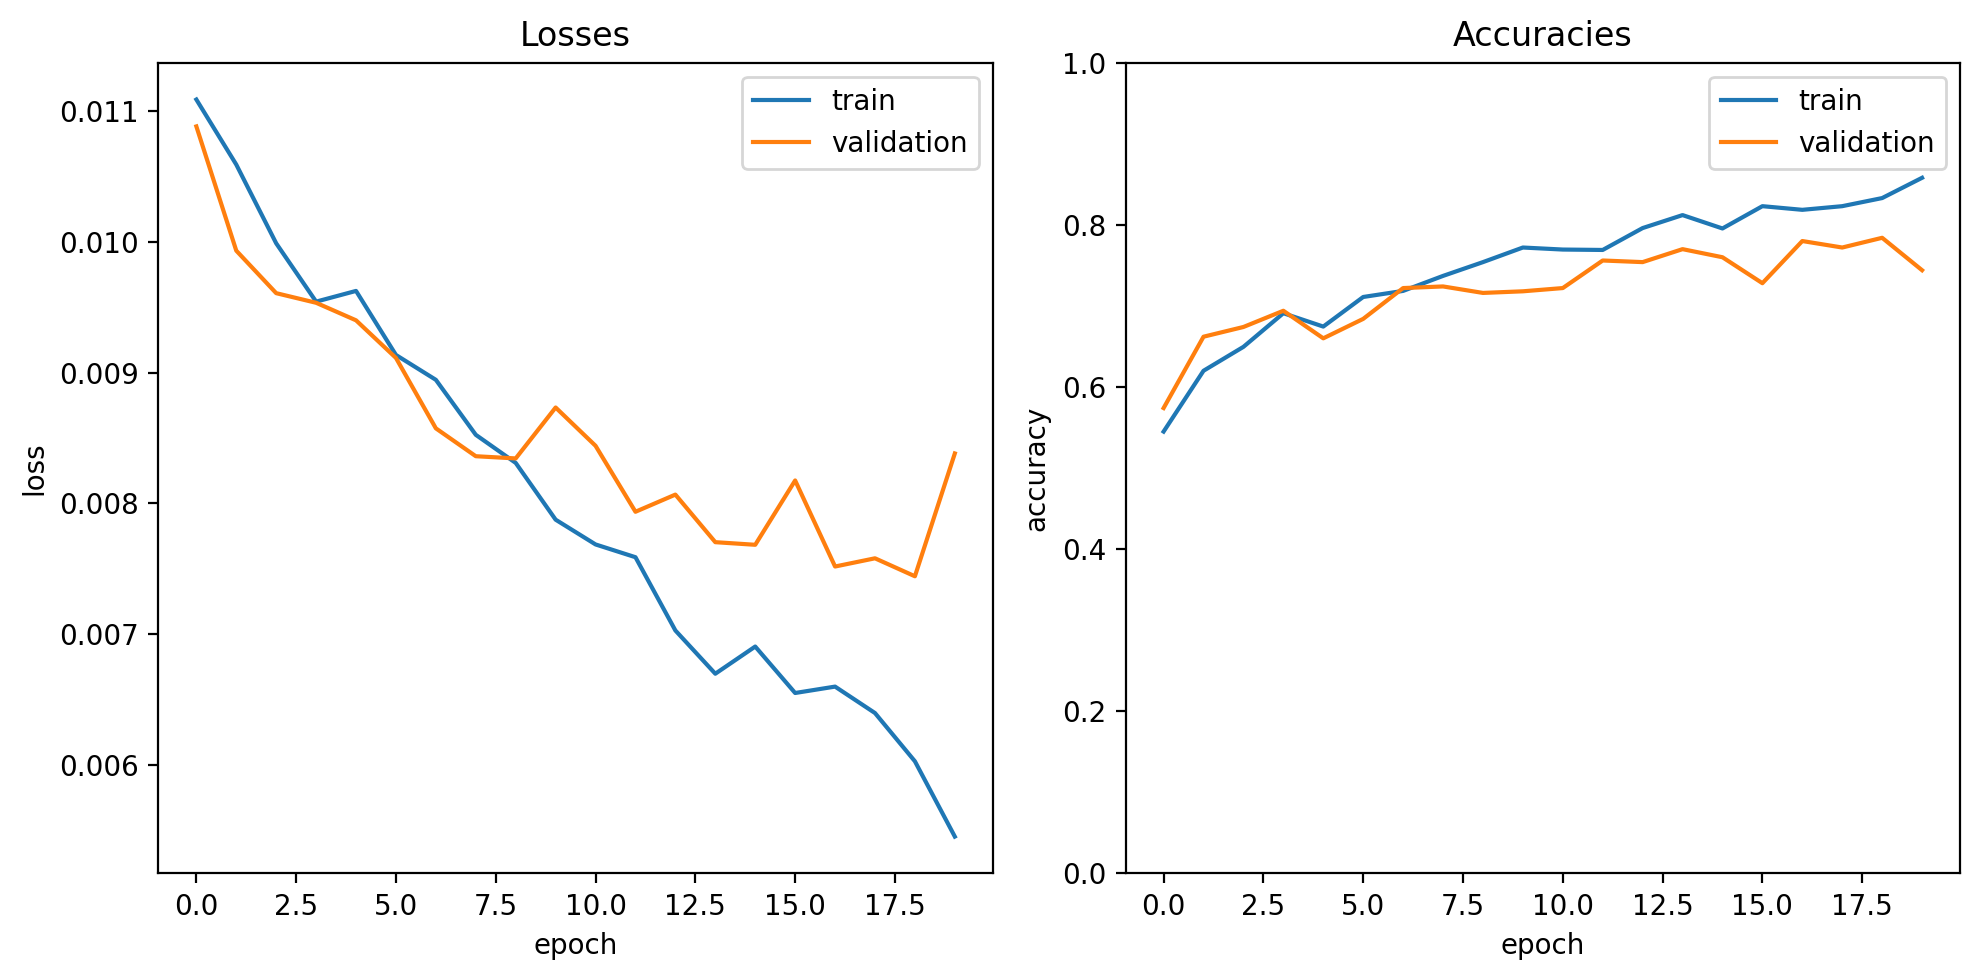

In [ ]:
plt.figure(dpi=200, figsize=(10, 5))

plt.subplot(121)
plt.plot(train_losses, label='train')
plt.plot(validation_losses, label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Losses')
plt.legend()

plt.subplot(122)
plt.plot(train_accuracies, label='train')
plt.plot(validation_accuracies, label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.title('Accuracies')

plt.tight_layout()
plt.show()

Now, change your model to achieve at least 75% accuracy on validation set. Add Dropout and Batch Norm layers where needed. You can change the model you've implemented (including the model depth, activation functions, etc.), the optimizer (including the regularizer terms), and the augmentations.

#### Question
Looking at the loss and accuracy plots, can you see if your model overfits the trainig set? Why?


<font color='skyblue'>
"It seems that at some point, while the training loss continues to decrease, the validation loss does not decrease and may even increase. This indicates that the model is starting to overfit, as it is becoming too specific to the training data and not capturing the general underlying patterns.

However, I have saved the model parameters corresponding to the best validation accuracy. By doing so, we are selecting the model that performs best on the validation set. This helps us to ensure that we have a more generalized model that performs well on unseen data.
</font>

In [ ]:
# Change your model to achieve better accuracies

class CNN_cat_dog(torch.nn.Module):

    def __init__(self, in_channel):
        super().__init__()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p = 0.1)
        # input 256 output 128
        self.conv1 = nn.Conv2d(in_channels = in_channel, out_channels = 64, kernel_size = (7, 7), padding = (3, 3))
        self.maxp1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.bn1 = nn.BatchNorm2d(64)
        # input 128 output 128
        self.conv2 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = (5, 5), padding = (2, 2))

        # input 128 output 32
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (3, 3), padding = (1, 1), stride = (2, 2))
        self.maxp2  = nn.MaxPool2d(kernel_size = (2, 2))
        self.bn2 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = (3, 3), padding = (1, 1))

        # input 32 output 8
        self.conv5 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = (3, 3), padding = (1, 1), stride = (2, 2))
        self.maxp3  = nn.MaxPool2d(kernel_size = (2, 2))
        self.bn3 = nn.BatchNorm2d(256)

        self.conv6 = nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = (8, 8), padding =0)
        self.bn4 = nn.BatchNorm2d(512)
        self.fc = nn.Linear(in_features = 512, out_features = 1000)
        self.out = nn.Linear(in_features = 1000, out_features = 1)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # TODO
        x = self.conv1(x)
        x = self.maxp1(x)
        x = self.bn1(x)
        x = self.relu(x)

        y = self.conv2(x)
        x = x + y
        self.relu(x)

        x = self.conv3(x)
        x = self.maxp2(x)
        x = self.bn2(x)
        x = self.relu(x)

        y = self.conv4(x)
        x = x + y
        x = self.relu(x)

        x = self.conv5(x)
        x = self.maxp3(x)
        x = self.bn3(x)
        x = self.relu(x)

        x = self.conv6(x)
        x = self.bn4(x)
        x = self.relu(x)

        x = x.view(x.size(0), -1)
        x = self.dropout(self.fc(x))

        return self.sigmoid(self.out(x))


In [ ]:
N_EPOCHS = 10
BATCH_SIZE = 64

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, num_workers=2)
model = CNN_cat_dog(3)
model.to(device)

criterion = nn.BCELoss() # TODO
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001) # TODO

model.train()

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

pbar = tqdm(range(N_EPOCHS))

for i in pbar:
    total_train_loss = 0.0
    total_train_correct = 0.0
    total_validation_loss = 0.0
    total_validation_correct = 0.0
    best_val_accuracy = 0.0
    model.train()

    for batch in tqdm(train_dataloader, leave=False):
        # use `get_loss_and_correct` to perform a step and save train loss and corrects
        # TODO
        loss, correct = get_loss_and_correct(model, batch, criterion, device, False)
        step(loss, optimizer)

        total_train_loss += loss.item()
        total_train_correct += correct

    with torch.no_grad():
        for batch in validation_dataloader:
            # use `get_loss_and_correct` to perform a step and save validation loss and corrects
            # TODO
            loss, correct = get_loss_and_correct(model, batch, criterion, device)
            total_validation_correct += correct
            total_validation_loss += loss.item()


    mean_train_loss = total_train_loss / len(train_dataloader.dataset) # TODO
    train_accuracy = total_train_correct / len(train_dataloader.dataset) # TODO

    mean_validation_loss = total_validation_loss / len(validation_dataloader.dataset) # TODO
    validation_accuracy = total_validation_correct / len(validation_dataloader.dataset) # TODO

    if validation_accuracy > best_val_accuracy:
        torch.save(model.state_dict(), 'best_model.pth')  # Save the model's state_dict
        best_val_accuracy = validation_accuracy


    train_losses.append(mean_train_loss)
    validation_losses.append(mean_validation_loss)

    train_accuracies.append(train_accuracy)
    validation_accuracies.append(validation_accuracy)

    pbar.set_postfix({'train_loss': mean_train_loss, 'validation_loss': mean_validation_loss, 'train_accuracy': train_accuracy, 'validation_accuracy': validation_accuracy})

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

### Testing the model

Now, use the `test_dataset` to get the final accuracy of your model. Visualize some correctly and incorrectly classified examples.

In [ ]:
# TODO
# 1. Calculate and show the test_dataset accuracy of your model.
# 2. Visualize some correctly and incorrectly classified examples.
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=2)

checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint)

total_test_correct = 0.0
total_test_loss = 0.0
preds = []
trues = []
imgs = []
with torch.no_grad():
    model.eval()
    for batch in test_dataloader:
        # use `get_loss_and_correct` to perform a step and save validation loss and corrects
        # TODO
        # loss, correct = get_loss_and_correct(model, batch, criterion, device)
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        targets = targets.view(targets.shape[0], 1).float()
        loss = criterion(outputs, targets)
        predicted = torch.round(outputs)

        correct = (predicted == targets).sum().item()

        total_test_correct += correct
        total_test_loss += loss.item()

        preds += predicted.cpu()
        trues += targets.cpu()
        imgs += inputs.cpu()

mean_test_loss = total_test_loss / len(test_dataloader.dataset) # TODO
test_accuracy = total_test_correct / len(test_dataloader.dataset) # TODO

print(f'test acc: {test_accuracy*100: .2f}, test_loss: {mean_test_loss: .4f}')

test acc:  73.80, test_loss:  0.0092


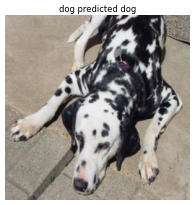

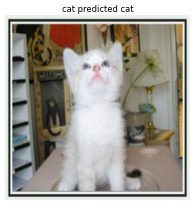

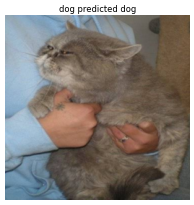

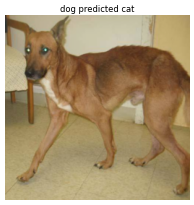

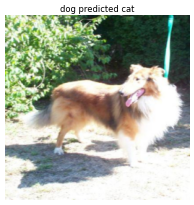

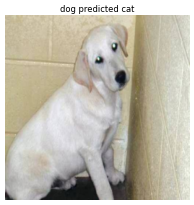

In [ ]:
# cat is 0 dog is 1
map = {0:'cat', 1:'dog'}

mismatch = 0
truematch = 0
idx = 0
while True:
    if predicted[idx] == targets[idx] and truematch < 3:
        truematch += 1
        show_normalized_image(imgs[idx], map[int(targets[idx][0].item())]+ ' predicted ' + map[int(predicted[idx][0].item())])
        plt.show()
    if predicted[idx] != targets[idx] and mismatch < 3:
        mismatch += 1
        show_normalized_image(imgs[idx], map[int(targets[idx][0].item())]+ ' predicted ' + map[int(predicted[idx][0].item())])
        plt.show()
    idx += 1
    if truematch == 3 and mismatch == 3:
      break

### Visualizing filters

In this part, we are going to visualize the output of one of the convolutional layers to see what features they focus on.

First, let's get some image.

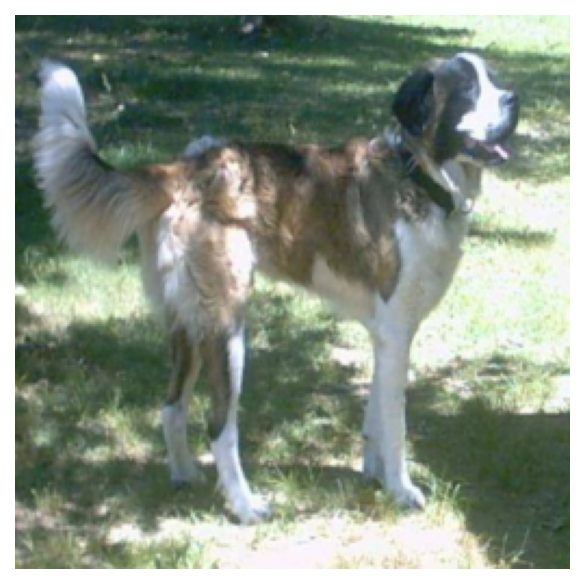

In [ ]:
image = validation_dataset[10][0]
show_normalized_image(image)

Now, we are going to *clip* our model at different points to get different intermediate representation.
* Clip your model at two or three different points and plot the filters output.

In order to clip the model, you can use `model.children()` method. For example, to get output only after the first 4 layers, you can do:

```
clipped = nn.Sequential(
    *list(model.children()[:2])
)
intermediate_output = clipped(input)
```



In [ ]:
# generate the intermediate output and print its shape
# TODO
def intermed(model, point, input):
    clipped_model = nn.Sequential(*list(model.children())[:point])

    with torch.no_grad():
        clipped_model.eval()
        input = input.to(device)
        clipped = clipped_model(input)
    return clipped.cpu()

image = validation_dataset[10][0]
image = image.view(1, image.shape[0], image.shape[1], image.shape[2])
print(intermed(model, 4, image).shape)

torch.Size([1, 64, 128, 128])


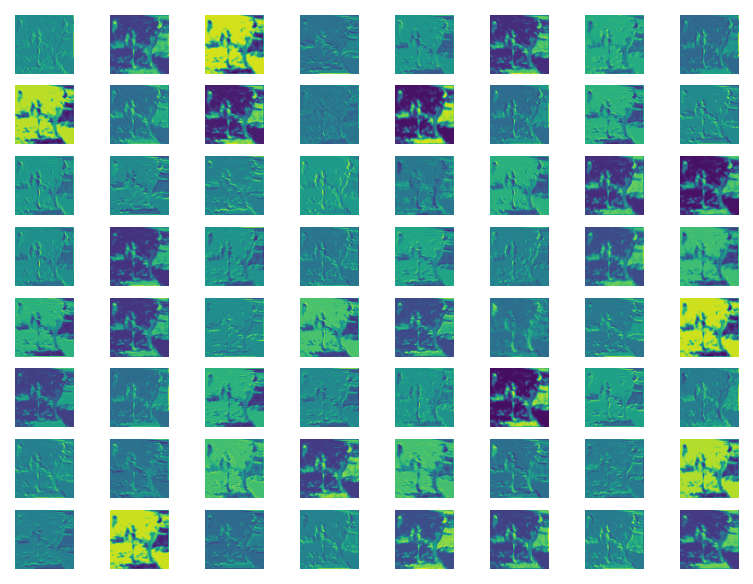

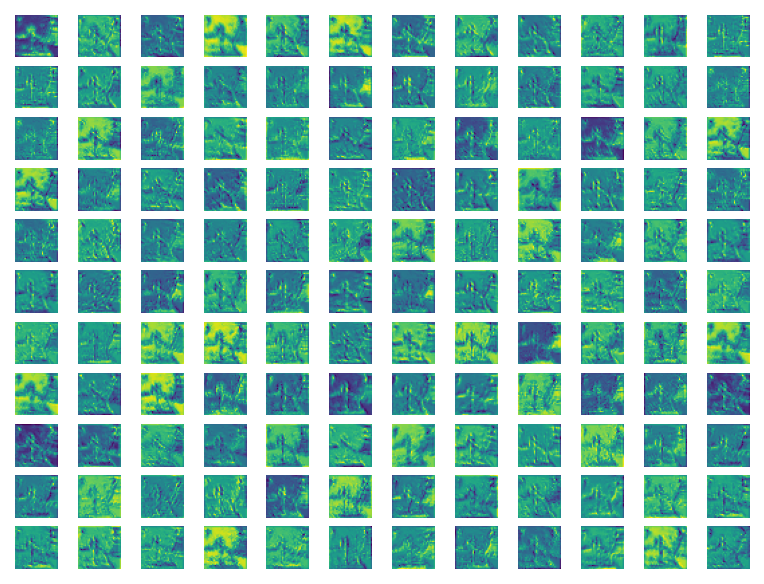

In [ ]:
import math

def plot_intermediate_output(result, title=None):
    """ Plots the intermediate output of shape
      N_FILTERS x H x W
    """
    plt.rcParams['figure.dpi'] = 150
    n_filters = result.shape[1]
    N = int(math.sqrt(n_filters))
    M = (n_filters + N - 1) // N
    assert N * M >= n_filters

    fig, axs = plt.subplots(N, M)
    fig.suptitle(title)

    for i in range(N):
        for j in range(M):
            if i*N + j < n_filters:
                axs[i][j].imshow(result[0, i*N + j].cpu().detach())
                axs[i][j].axis('off')
    plt.show()
# TODO:
# pick a few intermediate representations from your
# network and plot them using the provided function.
space = [4, 10]
for i in range(len(space)):
    gen = intermed(model, space[i], image)
    plot_intermediate_output(gen)


### Question
What can you say about those filters? What features are they focusing on?

<font color='skyblue'>
When examining intermediate values, we understand many things. For example, they focus on various aspects such as light, shadows, and lines with high contrast on their sides. For instance, the outline of the dog's body is significant for them. Apparently, they focus on diverse features of the image. For example, they may concentrate on different points with varying depths. Alternatively, in some cases, they focus on the structure, and most of the image may have the same color but distinct lines or structures.
</font>